In [1]:
# Plots for section 4.3 (mv and technology operation)

In [2]:
# TODO

## Imports

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import pypsa
import math
import seaborn as sns
import cartopy
import cartopy.crs as ccrs
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
from shapely.geometry import Point, LineString
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from datetime import date, datetime, time, timedelta

# imported own functions
from utils import market_values, market_values_by_time_index, nodal_balance, capacity, capacity_links, \
    capacity_storage_units, get_condense_sum, nodal_balance, generation, generation_links, \
    generation_storage_units, market_values_storage_units, market_values_links, time_stored_LIFO

# imported own definitions
from utils import carrier_colors, carrier_renaming, carrier_renaming_reverse
from utils import resistive_heater, gas_boiler, heat_pump,water_tanks_charger, water_tanks_discharger, solar_thermal
from utils import c_el_gen_s, c_el_con_s

# general variables
font1 = {'fontname': 'Calibri'}
PLOT_DIR = 'C:/Users/Julian/Studies/Master/01 TU Berlin/3. Semester - Masterarbeit/MA Marktwerte FEE/data/plots/01_general/4.3_systems_mv'
onshore_regions = gpd.read_file("../data/external/regions_onshore_elec_s_181.geojson")
offshore_regions = gpd.read_file("../data/external/regions_offshore_elec_s_181.geojson")
onshore_regions = onshore_regions.set_index('name')
offshore_regions = offshore_regions.set_index('name')

# Network imports
stst = pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")
exp = pypsa.Network("../data/raw/elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc")

# Notebook Definitions
c1_groups = [resistive_heater, gas_boiler, heat_pump, water_tanks_charger, water_tanks_discharger, solar_thermal]
c1_groups_name = ["resistive heater", "gas boiler", "heat pump", "water tanks charger", "water tanks discharger",
                  "solar thermal"]
markers = ["v", "^", "<", ">", "1", "2", "3", "4", "*", "+", "d", "o", "|", "s", "P", "p", "h"]

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lvopt__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [4]:
# stst and exp dataframes
df_stst_ons = pd.read_pickle("../data/processed/df_stst_ons.pkl")
df_stst_off = pd.read_pickle("../data/processed/df_stst_off.pkl")
df_exp_ons = pd.read_pickle("../data/processed/df_exp_ons.pkl")
df_exp_off = pd.read_pickle("../data/processed/df_exp_off.pkl")

In [5]:
# Notebook Functions

def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g


## General (4.3.1)

#### MV across regions

In [6]:
# Further investigation:

df_stst_ons[[c + "_mv" for c in c_el_gen_s]].mean().mean()
df_exp_ons[[c + "_mv" for c in c_el_gen_s]].mean().mean()

df_stst_ons[[c + "_mv" for c in c_el_gen_s]].mean() - df_exp_ons[[c + "_mv" for c in c_el_gen_s]].mean()
(df_stst_ons[[c + "_mv" for c in c_el_gen_s]].mean() - df_exp_ons[[c + "_mv" for c in c_el_gen_s]].mean()) / df_stst_ons[[c + "_mv" for c in c_el_gen_s]].mean()

(df_stst_ons[[c + "_mv" for c in c_el_gen_s]].describe().loc["75%"] - df_stst_ons[[c + "_mv" for c in c_el_gen_s]].describe().loc["25%"]) - (df_exp_ons[[c + "_mv" for c in c_el_gen_s]].describe().loc["75%"] - df_exp_ons[[c + "_mv" for c in c_el_gen_s]].describe().loc["25%"])

(df_stst_ons[[c + "_mv" for c in c_el_gen_s]].describe().loc["std"] - df_exp_ons[[c + "_mv" for c in c_el_gen_s]].describe().loc["std"])

df_stst_ons[[c + "_mv" for c in c_el_gen_s]].mean().sort_values()
df_exp_ons[[c + "_mv" for c in c_el_gen_s]].mean().sort_values()

solar_mv                                  53.106943
offwind-dc_mv                             59.484653
onwind_mv                                 59.767738
solar rooftop_mv                          61.879931
offwind-ac_mv                             64.252101
battery discharger_mv                     73.859110
ror_mv                                    75.384933
V2G_mv                                    82.827964
urban central solid biomass CHP CC_mv    110.078119
hydro_mv                                 110.219548
PHS_mv                                   118.023294
urban central gas CHP_mv                 279.006066
dtype: float64

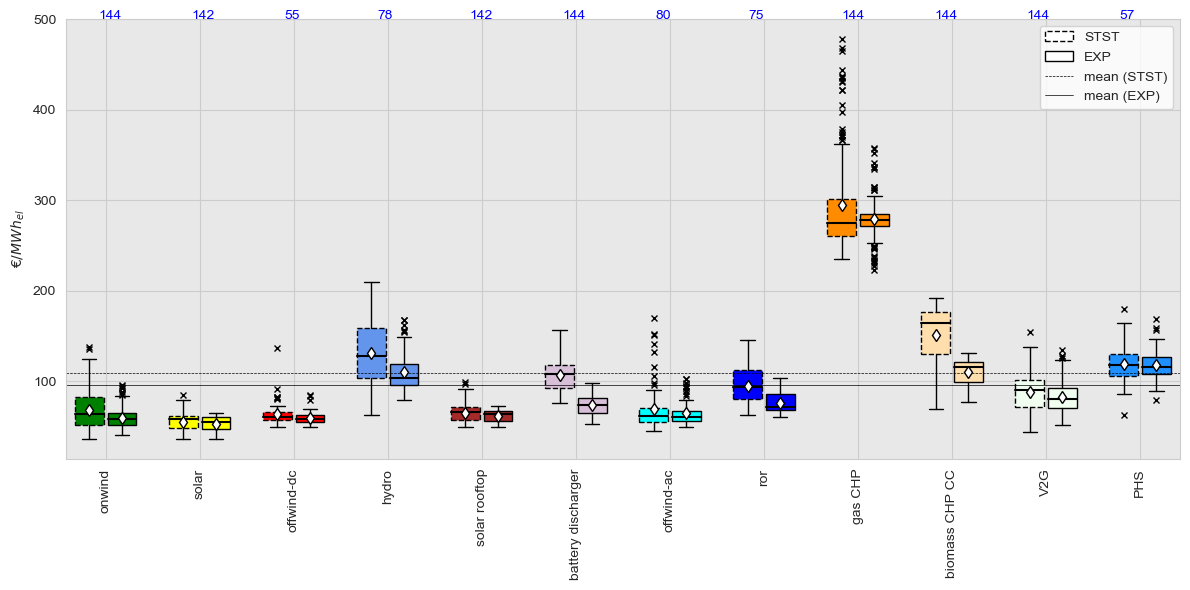

In [7]:
# electricity generating technologies

# boxplot propertes
medianprops = dict(color="black",linewidth=1.5)
meanprops = {"marker":"d","markerfacecolor":"white", "markeredgecolor":"black"}
flierprops= {'marker': 'x', 'markersize': 5, 'markeredgecolor': 'black'}
whiskerprops = dict(linestyle='-',linewidth=1.0, color='black')

# data
stst_el_gen = df_stst_ons[[c + "_mv" for c in c_el_gen_s]]
stst_el_gen = stst_el_gen.values
exp_el_gen = df_exp_ons[[c + "_mv" for c in c_el_gen_s]]
exp_el_gen = exp_el_gen.values

# Filter data using np.isnan
mask_stst = ~np.isnan(stst_el_gen)
filtered_stst = [d[m] for d, m in zip(stst_el_gen.T, mask_stst.T)]
mask_exp = ~np.isnan(exp_el_gen)
filtered_exp = [d[m] for d, m in zip(exp_el_gen.T, mask_exp.T)]

ticks = [carrier_renaming.get(n, n) for n in c_el_gen_s]
index = c_el_gen_s
fig, ax = plt.subplots(figsize=(12, 6))

stst_plot = plt.boxplot(filtered_stst,
                        positions=np.array(np.arange(len(ticks)))*2.0-0.35,
                        widths=0.6,
                        patch_artist=True,
                        showmeans=True,
                        meanprops=meanprops,
                        medianprops=medianprops,
                        flierprops=flierprops,
                        whiskerprops=whiskerprops
                        )

exp_plot = plt.boxplot(filtered_exp,
                       positions=np.array(np.arange(len(ticks)))*2.0+0.35,
                       widths=0.6,
                       patch_artist=True,
                       showmeans=True,
                       meanprops=meanprops,
                       medianprops=medianprops,
                       flierprops=flierprops,
                       whiskerprops=whiskerprops
                       )


for box, col in zip(stst_plot['boxes'],[carrier_colors[c] for c in index]):
    # change outline color
    box.set_facecolor(col)
    box.set_linestyle('--')

for box, col in zip(exp_plot['boxes'],[carrier_colors[c] for c in index]):
    # change outline color
    box.set_facecolor(col)

# sample sizes
for i, sample_size in enumerate(df_stst_ons[[f"{i}_mv" for i in index]].count()):
    ax.annotate(sample_size, xy=(0,0),  xycoords='axes fraction',
        xytext=((i+0.35)/len(index),1), textcoords='axes fraction', color="blue")

#for i, sample_size in enumerate(df_exp_ons[[f"{i}_mv" for i in index]].count()):
#    ax.annotate(sample_size, xy=(0,0),  xycoords='axes fraction',
#        xytext=((i+0.55)/len(index),1), textcoords='axes fraction', color="red")

# explanations
plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)
plt.ylabel("$€/MWh_{el}$")
plt.xticks(rotation=90)
# plt.title("Market values of electricity generating technologies across the regions (STST vs. EXP)", fontsize=16, pad=20,  **font1)

# cosmetics
ax.patch.set_facecolor('lightgrey')
ax.patch.set_alpha(0.5)

# horizontal lines
ax.axhline(df_stst_ons[[c + "_mv" for c in c_el_gen_s]].mean().mean(), ls="--", c='black',linewidth=0.5)
ax.axhline(df_exp_ons[[c + "_mv" for c in c_el_gen_s]].mean().mean(), ls="-", c='black', linewidth=0.5)

# legend
patch1 = matplotlib.patches.Patch(ls="--", facecolor="white", edgecolor="black")
patch2 = matplotlib.patches.Patch(ls="-", facecolor="white", edgecolor="black")
line1 = Line2D([0], [0], ls="--", c='black', label="mean (STST)", linewidth=0.5)
line2 = Line2D([0], [0], ls="-", c='black', label="mean (EXP)", linewidth=0.5)
ax.legend([patch1, patch2, line1, line2], ['STST', 'EXP', 'mean (STST)','mean (EXP)'])

fig.tight_layout()
plt.show()

# fig.savefig(f"{PLOT_DIR}/mv_el_gen_both_box.png")

In [8]:
# electricity consuming technologies
c_el_con_s

['H2 Electrolysis',
 'BEV charger',
 'battery charger',
 'urban central air heat pump',
 'urban central resistive heater',
 'PHS']

In [9]:
# exclude ones with less than 50 TWh consumption in both scenarios: home battery charger
#df_exp_ons["H2 Electrolysis_con_el"].sum() < 50*1e3

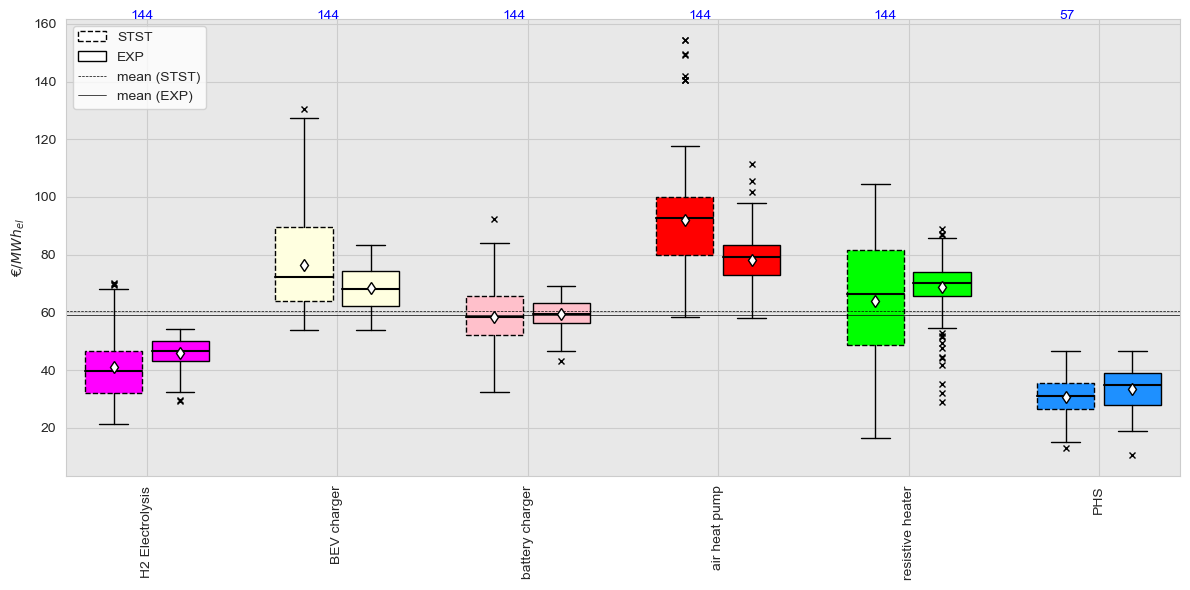

In [10]:
# electricity consuming technologies

# boxplot properties
medianprops = dict(color="black",linewidth=1.5)
meanprops = {"marker":"d","markerfacecolor":"white", "markeredgecolor":"black"}
flierprops= {'marker': 'x', 'markersize': 5, 'markeredgecolor': 'black'}
whiskerprops = dict(linestyle='-',linewidth=1.0, color='black')

# data
stst_el_con = df_stst_ons[[c + "_cost_mv_el" for c in c_el_con_s]]
stst_el_con = stst_el_con.values
exp_el_con = df_exp_ons[[c + "_cost_mv_el" for c in c_el_con_s]]
exp_el_con = exp_el_con.values

# Filter data using np.isnan
mask_stst = ~np.isnan(stst_el_con)
filtered_stst = [d[m] for d, m in zip(stst_el_con.T, mask_stst.T)]
mask_exp = ~np.isnan(exp_el_con)
filtered_exp = [d[m] for d, m in zip(exp_el_con.T, mask_exp.T)]

ticks = [carrier_renaming.get(n, n) for n in c_el_con_s]
index = c_el_con_s
fig, ax = plt.subplots(figsize=(12, 6))

stst_plot = plt.boxplot(filtered_stst,
                        positions=np.array(np.arange(len(ticks)))*2.0-0.35,
                        widths=0.6,
                        patch_artist=True,
                        showmeans=True,
                        meanprops=meanprops,
                        medianprops=medianprops,
                        flierprops=flierprops,
                        whiskerprops=whiskerprops
                        )

exp_plot = plt.boxplot(filtered_exp,
                       positions=np.array(np.arange(len(ticks)))*2.0+0.35,
                       widths=0.6,
                       patch_artist=True,
                       showmeans=True,
                       meanprops=meanprops,
                       medianprops=medianprops,
                       flierprops=flierprops,
                       whiskerprops=whiskerprops
                       )


for box, col in zip(stst_plot['boxes'],[carrier_colors[c] for c in index]):
    # change outline color
    box.set_facecolor(col)
    box.set_linestyle('--')

for box, col in zip(exp_plot['boxes'],[carrier_colors[c] for c in index]):
    # change outline color
    box.set_facecolor(col)

# sample sizes
for i, sample_size in enumerate(df_stst_ons[[f"{i}_cost_mv_el" for i in index]].count()):
    ax.annotate(sample_size, xy=(0,0),  xycoords='axes fraction',
        xytext=((i+0.35)/len(index),1), textcoords='axes fraction', color="blue")

#for i, sample_size in enumerate(df_exp_ons[[f"{i}_cost_mv_el" for i in index]].count()):
#    ax.annotate(sample_size, xy=(0,0),  xycoords='axes fraction',
#        xytext=((i+0.55)/len(index),1), textcoords='axes fraction', color="red")

# explanations
plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)
plt.ylabel("$€/MWh_{el}$")
plt.xticks(rotation=90)
# plt.title("Market values of electricity consuming technologies across the regions (STST vs. EXP)", fontsize=16, pad=20,  **font1)

# cosmetics
ax.patch.set_facecolor('lightgrey')
ax.patch.set_alpha(0.5)

# horizontal lines
ax.axhline(df_stst_ons[[c + "_cost_mv_el" for c in c_el_con_s]].mean().mean(), ls="--", c='black',linewidth=0.5)
ax.axhline(df_exp_ons[[c + "_cost_mv_el" for c in c_el_con_s]].mean().mean(), ls="-", c='black', linewidth=0.5)

# legend
patch1 = matplotlib.patches.Patch(ls="--", facecolor="white", edgecolor="black")
patch2 = matplotlib.patches.Patch(ls="-", facecolor="white", edgecolor="black")
line1 = Line2D([0], [0], ls="--", c='black', label="mean (STST)", linewidth=0.5)
line2 = Line2D([0], [0], ls="-", c='black', label="mean (EXP)", linewidth=0.5)
ax.legend([patch1, patch2, line1, line2], ['STST', 'EXP', 'mean (STST)','mean (EXP)'], loc="upper left")

fig.tight_layout()
plt.show()

fig.savefig(f"{PLOT_DIR}/mv_el_con_both_box.png")

In [11]:
# Further investigation
df_stst_ons[[c + "_cost_mv_el" for c in c_el_con_s]].mean().mean()
df_exp_ons[[c + "_cost_mv_el" for c in c_el_con_s]].mean().mean()

df_stst_ons[[c + "_cost_mv_el" for c in c_el_con_s]].mean() - df_exp_ons[[c + "_cost_mv_el" for c in c_el_con_s]].mean()

(df_stst_ons[[c + "_cost_mv_el" for c in c_el_con_s]].describe().loc["75%"] -
 df_stst_ons[[c + "_cost_mv_el" for c in c_el_con_s]].describe().loc["25%"]) - (
            df_exp_ons[[c + "_cost_mv_el" for c in c_el_con_s]].describe().loc["75%"] -
            df_exp_ons[[c + "_cost_mv_el" for c in c_el_con_s]].describe().loc["25%"])

(df_stst_ons[[c + "_cost_mv_el" for c in c_el_con_s]].describe().loc["std"] -
 df_exp_ons[[c + "_cost_mv_el" for c in c_el_con_s]].describe().loc["std"])

df_stst_ons[[c + "_cost_mv_el" for c in c_el_con_s]].mean().sort_values()

PHS_cost_mv_el                               30.728647
H2 Electrolysis_cost_mv_el                   40.943795
battery charger_cost_mv_el                   58.425525
urban central resistive heater_cost_mv_el    63.987767
BEV charger_cost_mv_el                       76.584520
urban central air heat pump_cost_mv_el       92.160160
dtype: float64

## Spatial Differences (4.3.2)

### Spatial correlation of mv, gen

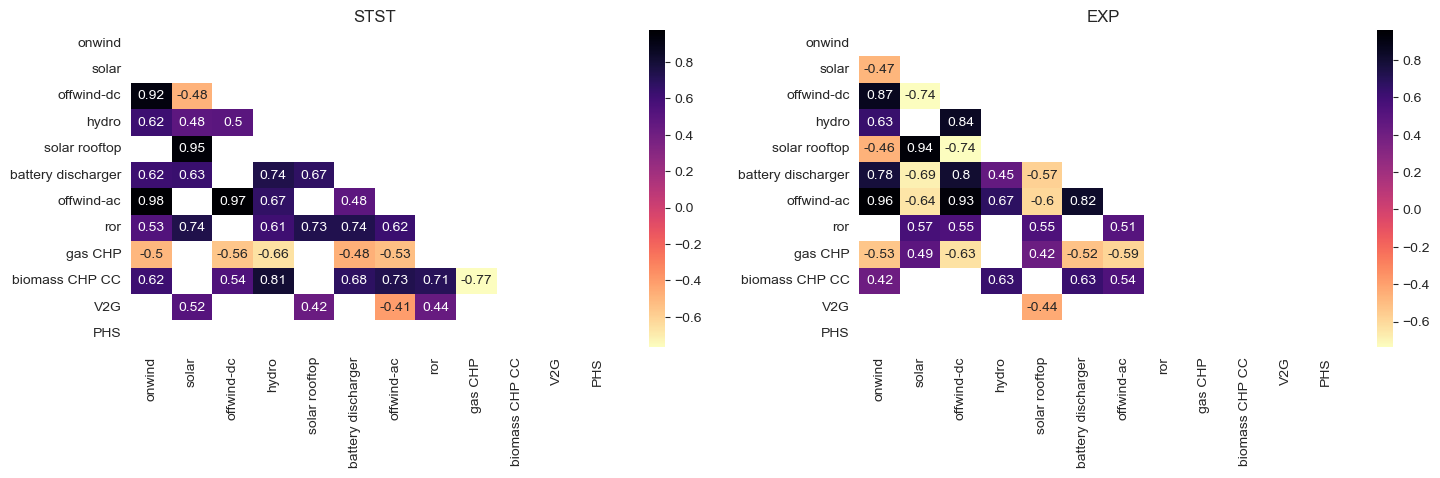

In [12]:
# Spatial correlation of mv

fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

for i, df, ax in zip([0,1], [df_stst_ons, df_exp_ons], axs):

    corr = df[[c + "_mv" for c in c_el_gen_s]].corr()
    corr.index = [carrier_renaming.get(n, n) for n in c_el_gen_s]
    corr.columns = [carrier_renaming.get(n, n) for n in c_el_gen_s]
    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(corr[abs(corr) > 0.4], mask=mask, cmap="magma_r", annot=True, ax=ax)
    ax.set_title('STST' if i == 0 else 'EXP')

fig.tight_layout(pad=1.5)
plt.show()

#fig.savefig(f"{PLOT_DIR}/mv_el_gen_both_corr.png")

In [13]:
# Spatial correlation of purchasing prices

fig, axs = plt.subplots(ncols=2, figsize=(8, 3))

for df, ax in zip([df_stst_ons, df_exp_ons], axs):
    corr = df[[c + "_cost_mv_el" for c in c_el_con_s]].corr()
    corr.index = [carrier_renaming.get(n, n) for n in c_el_con_s]
    corr.columns = [carrier_renaming.get(n, n) for n in c_el_con_s]

    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(corr[abs(corr) > 0.5], mask=mask, cmap="magma_r", annot=True, ax=ax)
fig.tight_layout(pad=1.5)

plt.close()
plt.show()

In [14]:
# Spatial correlation of both

fig, axs = plt.subplots(ncols=2, figsize=(17, 6))

for df, ax in zip([df_stst_ons, df_exp_ons], axs):
    corr = df[[c + "_mv" for c in c_el_gen_s] + [c + "_cost_mv_el" for c in c_el_con_s]].corr()
    corr.index = [carrier_renaming.get(n, n) for n in c_el_gen_s] + [carrier_renaming.get(n, n) + " (con)" for n in c_el_con_s]
    corr.columns = [carrier_renaming.get(n, n) for n in c_el_gen_s] + [carrier_renaming.get(n, n)+ " (con)" for n in c_el_con_s]

    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(corr[abs(corr) > 0.5], mask=mask, cmap="magma_r", annot=True, ax=ax)
fig.tight_layout(pad=1.5)
plt.close()
plt.show()

In [15]:
# correlation analysis
# what do you want to find?


corr_gini_res = pd.DataFrame(index=c_el_gen_s, columns=[["corr_mv_gen_STST", "cor_mv_gen_EXP", "gini_gen_STST", "gini_gen_EXP", "gini_gen_diff_EXP-STST", "gini_mv_STST", "gini_mv_EXP", "gini_mv_diff_EXP-STST"]])
for c in c_el_gen_s:
    corr_gini_res.loc[c,"corr_mv_gen_STST"] = df_stst_ons[f"{c}_mv"].corr(df_stst_ons[f"{c}_gen"])
    corr_gini_res.loc[c,"cor_mv_gen_EXP"] = df_exp_ons[f"{c}_mv"].corr(df_exp_ons[f"{c}_gen"])
    corr_gini_res.loc[c,"gini_gen_STST"] = gini(df_stst_ons[[f"{c}_gen"]].dropna().values)
    corr_gini_res.loc[c,"gini_gen_EXP"] = gini(df_exp_ons[[f"{c}_gen"]].dropna().values)
    corr_gini_res.loc[c,"gini_gen_EXP"] = gini(df_exp_ons[[f"{c}_gen"]].dropna().values)
    corr_gini_res.loc[c,"gini_mv_STST"] = gini(df_stst_ons[[f"{c}_mv"]].dropna().values)
    corr_gini_res.loc[c,"gini_mv_EXP"] = gini(df_exp_ons[[f"{c}_mv"]].dropna().values)

corr_gini_res["gini_gen_diff_EXP-STST"] = corr_gini_res["gini_gen_EXP"].values - corr_gini_res["gini_gen_STST"].values
corr_gini_res["gini_mv_diff_EXP-STST"] = corr_gini_res["gini_mv_EXP"].values - corr_gini_res["gini_mv_STST"].values
corr_gini_res

,corr_mv_gen_STST,cor_mv_gen_EXP,gini_gen_STST,gini_gen_EXP,gini_gen_diff_EXP-STST,gini_mv_STST,gini_mv_EXP,gini_mv_diff_EXP-STST
onwind,-0.578121,-0.509373,0.659884,0.757872,0.097988,0.166482,0.106267,-0.060214
solar,-0.492272,-0.622834,0.537442,0.74862,0.211178,0.097581,0.086275,-0.011306
offwind-dc,-0.217228,-0.305526,0.805011,0.854884,0.049873,0.089491,0.059508,-0.029983
hydro,-0.365901,-0.081002,0.649592,0.64958,-0.000011,0.172735,0.096759,-0.075976
solar rooftop,-0.297527,-0.549038,0.581368,0.665008,0.083641,0.07896,0.055691,-0.023269
battery discharger,0.092893,0.453821,0.785734,0.953217,0.167483,0.094045,0.085976,-0.008069
offwind-ac,-0.122878,-0.121677,0.91263,0.935982,0.023352,0.161479,0.100568,-0.06091
ror,-0.111448,-0.204951,0.667172,0.665983,-0.001189,0.116108,0.072561,-0.043546
urban central gas CHP,-0.217368,0.265516,0.674886,0.704973,0.030087,0.090972,0.040666,-0.050306
urban central solid biomass CHP CC,0.524688,0.436093,0.782093,0.77208,-0.010013,0.111417,0.068683,-0.042734


**Findings:**
- gini: the higher, the more uneven distributed
- generation is more uneven distributed in EXP case
- mv are more evenly distributed in EXP case

### Electricity producing technologies

#### VRE

In [16]:
# VRE

# market values across regions as map
carriers = ["onwind", "solar","offwind-dc", "ror"]

fig, axs = plt.subplots(ncols=2, nrows=2, subplot_kw={'projection': ccrs.EqualEarth()},
                        figsize=(18, 16))
crs = ccrs.EqualEarth()

for i, ax in enumerate(axs.reshape(-1)):

    if carriers[i] in ["offwind-dc", "offwind-ac"]:
        df = df_stst_off
    else:
        df = df_stst_ons

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    df.to_crs(crs.proj4_init).plot(column=f"{carriers[i]}_mv",
                                   ax=ax,
                                   cmap=plt.get_cmap("magma_r"),
                                   linewidth=0.05,
                                   edgecolor = 'grey',
                                   legend=True,
                                   legend_kwds={'label':"market values ($€/MWh_{el}$)",'orientation': "vertical",'shrink' : 0.9}
                                   )

    max_size = df[f"{carriers[i]}_gen"].max()
    df.to_crs(crs.proj4_init).centroid.plot(ax=ax, sizes=df[f"{carriers[i]}_gen"] / max_size *300,  color="black", edgecolor="white")
    pypsa.plot.add_legend_circles(ax=ax, sizes=[0.6], labels=["Generation magnitude"], patch_kw={'color': 'black', 'edgecolor': 'white'}, legend_kw={'loc': 'upper left'})

    # always select same section
    xmin, ymin, xmax, ymax = df_stst_off.to_crs(crs.proj4_init).total_bounds
    pad = 1 * 1e5  # add a padding around the geometry
    ax.set_xlim(xmin-pad, xmax+pad)
    ax.set_ylim(ymin-pad, ymax+pad)

    ax.set_title(f"{carriers[i]}", fontsize=16, **font1)

# fig.suptitle("Spatial Differences in the electricity generation of the VRE technologies (STST)", fontsize=16, **font1)
fig.tight_layout()

plt.close()
plt.show()


# fig.savefig(f"{PLOT_DIR}/mv_el_gen_vre_STST_map.png")

In [17]:
# Further investigation
# TODO why is the correlation between mv and cp for ror positive
c_vre = ["onwind", "solar", "offwind-dc", "solar rooftop", "offwind-ac", "ror"]
for c in c_vre:
    print(c)
    print(df_stst_ons[f"{c}_mv"].corr(df_stst_ons[f"{c}_gen"]))
    print(df_stst_ons[f"{c}_mv"].corr(df_stst_ons[f"{c}_cf"]))

# generation weighted market value
c = "ror"
((df_stst_ons[f"{c}_gen"] / df_stst_ons[f"{c}_gen"].sum()) * df_stst_ons[f"{c}_mv"]).sum()

onwind
-0.5781209573863494
-0.7058179103669308
solar
-0.49227225813176906
-0.9120500457591202
offwind-dc
-0.21722843782978507
-0.7014675772678328
solar rooftop
-0.29752705945838803
-0.7818859621096502
offwind-ac
-0.12287773877776946
-0.7173872701307896
ror
-0.1114482098844423
0.652170303221742


91.207870116185

In [18]:
# VRE difference

# market values across regions as map
carriers = ["onwind", "solar","offwind-dc", "ror"]

for c in carriers:
    # if one mv is nan the result is nan as well
    if c in ["offwind-dc", "offwind-ac"]:
        df_stst_off[f"{c}_mv_STST-EXP"] = df_stst_off[f"{c}_mv"] - df_exp_off[f"{c}_mv"]
    else:
        df_stst_ons[f"{c}_mv_STST-EXP"] = df_stst_ons[f"{c}_mv"] - df_exp_ons[f"{c}_mv"]

fig, axs = plt.subplots(ncols=2, nrows=2, subplot_kw={'projection': ccrs.EqualEarth()},
                        figsize=(18, 16))
crs = ccrs.EqualEarth()

for i, ax in enumerate(axs.reshape(-1)):

    if carriers[i] in ["offwind-dc", "offwind-ac"]:
        df = df_stst_off
        df_2 = df_exp_off
    else:
        df = df_stst_ons
        df_2 = df_exp_ons

    abs_max = max(abs(df[f"{carriers[i]}_mv_STST-EXP"].max()) , abs(df[f"{carriers[i]}_mv_STST-EXP"].max()))

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    df.to_crs(crs.proj4_init).plot(column=f"{carriers[i]}_mv_STST-EXP",
                                   ax=ax,
                                   cmap=plt.get_cmap('RdYlGn'),
                                   vmax=abs_max,
                                   vmin=-abs_max,
                                   linewidth=0.05,
                                   edgecolor = 'grey',
                                   legend=True,
                                   legend_kwds={'label':"market value differences ($€/MWh_{el}$)",'orientation': "vertical",'shrink' : 0.8}
                                   )

    # difference in generation (STST-EXP)
    gen_diff = df[f"{carriers[i]}_gen"] - df_2[f"{carriers[i]}_gen"]
    # red if negative and green if positive
    colors = ['red' if (x < 0) else 'green' for x in gen_diff ]

    max_size = abs(gen_diff).max()
    df.to_crs(crs.proj4_init).centroid.plot(ax=ax, sizes=(abs(gen_diff) / max_size) * 500,  color=colors, edgecolor="white")
    circle1 = Line2D([], [], color="white", marker='o', markerfacecolor="green", markeredgecolor="white", markersize=10)
    circle2 = Line2D([], [], color="white", marker='o', markerfacecolor="red", markeredgecolor="white", markersize=10)
    circle3 = Line2D([], [], color="white", marker='o', markerfacecolor="white", markeredgecolor="black", markersize=10)

    unit = "TWh" if max_size > 1e3 else "GWh"
    max_size = max_size / 1e3 if max_size > 1e3 else max_size
    ax.legend((circle1, circle2, circle3), ('Increased production in STST', 'Increased production in EXP', f"max circle size: {round(max_size)} {unit}"), numpoints=1, loc="upper left")


    # always select same section
    xmin, ymin, xmax, ymax = df_stst_off.to_crs(crs.proj4_init).total_bounds
    pad = 1 * 1e5  # add a padding around the geometry
    ax.set_xlim(xmin-pad, xmax+pad)
    ax.set_ylim(ymin-pad, ymax+pad)

    ax.set_title(f"{carriers[i]} mv (STST - EXP)", fontsize=16, **font1)

# fig.suptitle("Spatial Differences in the electricity generation of the VRE technologies (STST)", fontsize=16, **font1)
fig.tight_layout()

plt.close()
plt.show()


#fig.savefig(f"{PLOT_DIR}/mv_el_gen_vre_STST-EXP_map.png")

#### Storage

In [19]:
# Storage

# market values across regions as map
carriers = ["hydro", "battery discharger", "V2G", "PHS"]

fig, axs = plt.subplots(ncols=2, nrows=2, subplot_kw={'projection': ccrs.EqualEarth()},
                        figsize=(18, 16))
crs = ccrs.EqualEarth()

for i, ax in enumerate(axs.reshape(-1)):

    if carriers[i] in ["offwind-dc", "offwind-ac"]:
        df = df_stst_off
    else:
        df = df_stst_ons

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    df.to_crs(crs.proj4_init).plot(column=f"{carriers[i]}_mv",
                                   ax=ax,
                                   cmap=plt.get_cmap("magma_r"),
                                   linewidth=0.05,
                                   edgecolor = 'grey',
                                   legend=True,
                                   legend_kwds={'label':"market values ($€/MWh_{el}$)",'orientation': "vertical",'shrink' : 0.9}
                                   )

    max_size = df[f"{carriers[i]}_gen"].max()
    df.to_crs(crs.proj4_init).centroid.plot(ax=ax, sizes=df[f"{carriers[i]}_gen"] / max_size *300,  color="black", edgecolor="white")
    pypsa.plot.add_legend_circles(ax=ax, sizes=[0.6], labels=["Generation magnitude"], patch_kw={'color': 'black', 'edgecolor': 'white'}, legend_kw={'loc': 'upper left'})

    # always select same section
    xmin, ymin, xmax, ymax = df_stst_off.to_crs(crs.proj4_init).total_bounds
    pad = 1 * 1e5  # add a padding around the geometry
    ax.set_xlim(xmin-pad, xmax+pad)
    ax.set_ylim(ymin-pad, ymax+pad)

    ax.set_title(f"{carriers[i]}", fontsize=16, **font1)

# fig.suptitle("Spatial Differences in the electricity generation of the VRE technologies (STST)", fontsize=16, **font1)
fig.tight_layout()

plt.close()
plt.show()


#fig.savefig(f"{PLOT_DIR}/mv_el_gen_store_STST_map.png")

In [20]:
# Storage difference

# market values across regions as map
carriers = ["hydro", "battery discharger", "V2G", "PHS"]

for c in carriers:
    # if one mv is nan the result is nan as well
    if c in ["offwind-dc", "offwind-ac"]:
        df_stst_off[f"{c}_mv_STST-EXP"] = df_stst_off[f"{c}_mv"] - df_exp_off[f"{c}_mv"]
    else:
        df_stst_ons[f"{c}_mv_STST-EXP"] = df_stst_ons[f"{c}_mv"] - df_exp_ons[f"{c}_mv"]

fig, axs = plt.subplots(ncols=2, nrows=2, subplot_kw={'projection': ccrs.EqualEarth()},
                        figsize=(18, 16))
crs = ccrs.EqualEarth()

for i, ax in enumerate(axs.reshape(-1)):

    if carriers[i] in ["offwind-dc", "offwind-ac"]:
        df = df_stst_off
        df_2 = df_exp_off
    else:
        df = df_stst_ons
        df_2 = df_exp_ons

    abs_max = max(abs(df[f"{carriers[i]}_mv_STST-EXP"].max()) , abs(df[f"{carriers[i]}_mv_STST-EXP"].max()))

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    df.to_crs(crs.proj4_init).plot(column=f"{carriers[i]}_mv_STST-EXP",
                                   ax=ax,
                                   cmap=plt.get_cmap('RdYlGn'),
                                   vmax=abs_max,
                                   vmin=-abs_max,
                                   linewidth=0.05,
                                   edgecolor = 'grey',
                                   legend=True,
                                   legend_kwds={'label':"market value differences ($€/MWh_{el}$)",'orientation': "vertical",'shrink' : 0.8}
                                   )

    # difference in generation (STST-EXP)
    gen_diff = df[f"{carriers[i]}_gen"] - df_2[f"{carriers[i]}_gen"]
    # red if negative and green if positive
    colors = ['red' if (x < 0) else 'green' for x in gen_diff ]

    max_size = abs(gen_diff).max()
    df.to_crs(crs.proj4_init).centroid.plot(ax=ax, sizes=(abs(gen_diff) / max_size) * 500,  color=colors, edgecolor="white")
    circle1 = Line2D([], [], color="white", marker='o', markerfacecolor="green", markeredgecolor="white", markersize=10)
    circle2 = Line2D([], [], color="white", marker='o', markerfacecolor="red", markeredgecolor="white", markersize=10)
    circle3 = Line2D([], [], color="white", marker='o', markerfacecolor="white", markeredgecolor="black", markersize=10)

    unit = "TWh" if max_size > 1e3 else "GWh"
    max_size = max_size / 1e3 if max_size > 1e3 else max_size
    ax.legend((circle1, circle2, circle3), ('Increased production in STST', 'Increased production in EXP', f"max circle size: {round(max_size)} {unit}"), numpoints=1, loc="upper left")


    # always select same section
    xmin, ymin, xmax, ymax = df_stst_off.to_crs(crs.proj4_init).total_bounds
    pad = 1 * 1e5  # add a padding around the geometry
    ax.set_xlim(xmin-pad, xmax+pad)
    ax.set_ylim(ymin-pad, ymax+pad)

    ax.set_title(f"{carriers[i]} mv (STST - EXP)", fontsize=16, **font1)

# fig.suptitle("Spatial Differences in the electricity generation of the VRE technologies (STST)", fontsize=16, **font1)
fig.tight_layout()

plt.close()
plt.show()


#fig.savefig(f"{PLOT_DIR}/mv_el_gen_store_STST-EXP_map.png")

In [21]:
# Storage
# "hydro", "battery discharger", "V2G", "PHS"

carriers = ["hydro", "V2G"]

fig, axs = plt.subplots(ncols=2, nrows=1, subplot_kw={'projection': ccrs.EqualEarth()}, figsize=(18, 8),
                        gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1]}
                        )
crs = ccrs.EqualEarth()

for i, ax in enumerate(axs):

    if carriers[i] in ["offwind-dc", "offwind-ac"]:
        df = df_stst_off
    else:
        df = df_stst_ons

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    df.to_crs(crs.proj4_init).plot(column=f"{carriers[i]}_mv",
                                   ax=ax,
                                   cmap=plt.get_cmap("magma_r"),
                                   linewidth=0.05,
                                   edgecolor = 'grey',
                                   legend=True,
                                   legend_kwds={'label':"market values ($€/MWh_{el}$)",'orientation': "vertical",'shrink' : 0.9}
                                   )

    max_size = df[f"{carriers[i]}_gen"].max()
    df.to_crs(crs.proj4_init).centroid.plot(ax=ax, sizes=df[f"{carriers[i]}_gen"] / max_size *300,  color="black", edgecolor="white")
    pypsa.plot.add_legend_circles(ax=ax, sizes=[0.6], labels=["Generation magnitude"], patch_kw={'color': 'black', 'edgecolor': 'white'}, legend_kw={'loc': 'upper left'})

    # always select same section
    xmin, ymin, xmax, ymax = df_stst_ons.to_crs(crs.proj4_init).total_bounds
    pad = 1 * 1e5  # add a padding around the geometry
    ax.set_xlim(xmin-pad, xmax+pad)
    ax.set_ylim(ymin-pad, ymax+pad)

    ax.set_title(f"{carriers[i]}", fontsize=16, **font1)

# fig.suptitle("Spatial Differences in the electricity generation of the VRE technologies (STST)", fontsize=16, **font1)
fig.tight_layout()

plt.close()
plt.show()


# fig.savefig(f"{PLOT_DIR}/mv_el_gen_stor_hydro_V2G_STST_map.png")

In [22]:
# plot difference

# Storage difference
# "hydro", "battery discharger", "V2G", "PHS"

carriers = ["hydro", "V2G"]
for c in carriers:
    # if one mv is nan the result is nan as well
    df_stst_ons[f"{c}_mv_STST-EXP"] = df_stst_ons[f"{c}_mv"] - df_exp_ons[f"{c}_mv"]

fig, axs = plt.subplots(ncols=2, nrows=1, subplot_kw={'projection': ccrs.EqualEarth()}, figsize=(18, 8),
                        gridspec_kw={'width_ratios': [1, 1], 'height_ratios': [1]}
                        )
crs = ccrs.EqualEarth()

for i, ax in enumerate(axs):

    if carriers[i] in ["offwind-dc", "offwind-ac"]:
        df = df_stst_off
    else:
        df = df_stst_ons

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    df.to_crs(crs.proj4_init).plot(column=f"{carriers[i]}_mv_STST-EXP",
                                   ax=ax,
                                   cmap=plt.get_cmap("magma_r"),
                                   linewidth=0.05,
                                   edgecolor = 'grey',
                                   legend=True,
                                   legend_kwds={'label':"market values ($€/MWh_{el}$)",'orientation': "vertical",'shrink' : 0.9}
                                   )

    max_size = df[f"{carriers[i]}_gen"].max()
    df.to_crs(crs.proj4_init).centroid.plot(ax=ax, sizes=df[f"{carriers[i]}_gen"] / max_size *300,  color="black", edgecolor="white")
    pypsa.plot.add_legend_circles(ax=ax, sizes=[0.6], labels=["Generation magnitude"], patch_kw={'color': 'black', 'edgecolor': 'white'}, legend_kw={'loc': 'upper left'})

    # always select same section
    xmin, ymin, xmax, ymax = df_stst_ons.to_crs(crs.proj4_init).total_bounds
    pad = 1 * 1e5  # add a padding around the geometry
    ax.set_xlim(xmin-pad, xmax+pad)
    ax.set_ylim(ymin-pad, ymax+pad)

    ax.set_title(f"{carriers[i]}", fontsize=16, **font1)

# fig.suptitle("Spatial Differences in the electricity generation of the VRE technologies (STST)", fontsize=16, **font1)
fig.tight_layout()

plt.close()
plt.show()


# fig.savefig(f"{PLOT_DIR}/mv_el_gen_stor_hydro_V2G_STST-EXP_map.png")

In [23]:
# Further investigation
c = "V2G"
df_stst_ons[[f"{c}_mv",f"{c}_gen"]].sort_values(by=f"{c}_mv")

,V2G_mv,V2G_gen
name,,
FR0 13,43.310151,402.433666
FR0 10,47.148184,667.599178
FR0 14,47.251985,803.144634
FR0 6,47.874754,698.784707
FR0 0,49.647158,593.684062
...,...,...
SE3 4,NaN,27.394292
SE3 5,NaN,58.449005
SE3 6,NaN,193.406725


In [24]:
df_exp_ons[[f"{c}_mv",f"{c}_gen"]].sort_values(by=f"{c}_mv")

,V2G_mv,V2G_gen
name,,
BE0 0,51.882724,227.050601
FR0 13,53.146641,254.387615
FR0 2,53.354636,133.366510
FR0 10,58.524568,517.106483
DE0 21,60.818561,210.803954
...,...,...
SE3 2,NaN,64.028873
SE3 4,NaN,27.554712
SE3 5,NaN,47.701271


In [25]:
# difference in mv
pd.concat([df_stst_ons[f"{c}_mv"] - df_exp_ons[f"{c}_mv"], df_stst_ons[f"{c}_gen"],df_exp_ons[f"{c}_gen"]], axis=1).sort_values(by=f"{c}_mv")

,V2G_mv,V2G_gen,V2G_gen
name,,,
GB5 16,-38.307316,847.803039,476.114523
HU0 1,-36.285789,504.506797,262.198867
RO0 2,-32.329032,593.760914,364.949765
RO0 0,-28.557459,640.205808,499.997329
GB5 4,-25.212819,659.584876,322.093579
...,...,...,...
SE3 4,NaN,27.394292,27.554712
SE3 5,NaN,58.449005,47.701271
SE3 6,NaN,193.406725,215.976825


In [26]:
for c in c_el_gen_s:
    print(c)
    mv_diff = df_stst_ons[f"{c}_mv"] - df_exp_ons[f"{c}_mv"]
    gen_diff = df_stst_ons[f"{c}_gen"] - df_exp_ons[f"{c}_gen"]
    print(mv_diff.corr(gen_diff))

onwind
0.10822705775898095
solar
0.058456045351544694
offwind-dc
0.02356215816871332
hydro
0.07169771277615203
solar rooftop
0.20916394317574333
battery discharger
0.12717408512498457
offwind-ac
-0.013527105651795981
ror
-0.1320800341754791
urban central gas CHP
-0.19662605778676534
urban central solid biomass CHP CC
0.26266908332028205
V2G
0.4640685857371483
PHS
0.009797263172737455


In [27]:
# Norway analysis
i_no = df_stst_ons.index[df_stst_ons.index.str.contains("NO")]
# generation weighted market value
c = "hydro"
((df_stst_ons.loc[i_no, f"{c}_gen"] / df_stst_ons.loc[i_no, f"{c}_gen"].sum()) * df_stst_ons.loc[i_no,f"{c}_mv"]).sum()
#df_stst_ons.loc[i_no, f"{c}_gen"].sum()

64.57308834155266

In [28]:
c = "V2G"
((df_exp_ons.loc[i_no, f"{c}_gen"] / df_exp_ons.loc[i_no, f"{c}_gen"].sum()) * df_exp_ons.loc[i_no,f"{c}_mv"]).sum()
df_exp_ons.loc[i_no, f"{c}_gen"].sum()

480.07453467701544

In [29]:
c_vre = ["hydro", "battery discharger", "V2G", "PHS"]
for c in c_vre:
    print(c)
    print(df_stst_ons[f"{c}_mv"].corr(df_stst_ons[f"{c}_gen"]))
    print(df_stst_ons[f"{c}_mv"].corr(df_stst_ons[f"{c}_cf"]))

hydro
-0.36590131214318605
-0.2463947308279008
battery discharger
0.09289282900912661
-0.5629960771686885
V2G
0.039088311345582716
-0.12858409569734894
PHS
0.4276816766873361
0.40453718374026076


In [30]:
c_vre = ["hydro", "battery discharger", "V2G", "PHS"]
for c in c_vre:
    print(c)
    print(df_exp_ons[f"{c}_mv"].corr(df_stst_ons[f"{c}_gen"]))
    print(df_exp_ons[f"{c}_mv"].corr(df_stst_ons[f"{c}_cf"]))

hydro
-0.0809884312975106
-0.567312826876331
battery discharger
0.5259746161125151
-0.7394803547201275
V2G
0.08326424694594128
-0.02051780301350492
PHS
0.45772184340906147
0.4972930912218569


In [31]:
# generation weighted market value
c = "hydro"
((df_stst_ons[f"{c}_gen"] / df_stst_ons[f"{c}_gen"].sum()) * df_stst_ons[f"{c}_mv"]).sum()

112.25335381604019

In [32]:
# generation weighted market value
c = "hydro"
((df_exp_ons[f"{c}_gen"] / df_exp_ons[f"{c}_gen"].sum()) * df_exp_ons[f"{c}_mv"]).sum()

107.57961092664445

In [33]:
# Storage: Battery Discharger

carriers = ["battery discharger", "battery discharger"]

fig, axs = plt.subplots(ncols=2, nrows=1, subplot_kw={'projection': ccrs.EqualEarth()},figsize=(18, 8),
                        gridspec_kw={'width_ratios': [1, 0.96], 'height_ratios': [1]})
crs = ccrs.EqualEarth()

# same colorbar withds:
vmin = min(np.nanmin(df_stst_ons[f"{carriers[i]}_mv"]), np.nanmin(df_exp_ons[f"{carriers[i]}_mv"]))
vmax = max(np.nanmax(df_stst_ons[f"{carriers[i]}_mv"]), np.nanmax(df_exp_ons[f"{carriers[i]}_mv"]))

for i, ax in enumerate(axs):

    if i == 0:
        df = df_stst_ons
    else:
        df = df_exp_ons

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    df.to_crs(crs.proj4_init).plot(column=f"{carriers[i]}_mv",
                                   ax=ax,
                                   cmap=plt.get_cmap("magma_r"),
                                   vmin=vmin,
                                   vmax=vmax,
                                   linewidth=0.05,
                                   edgecolor = 'grey',
                                   legend=True,
                                   legend_kwds={'label':"market values ($€/MWh_{el}$)",'orientation': "vertical",'shrink' : 0.9}
                                   )

    max_size = df[f"{carriers[i]}_gen"].max()
    df.to_crs(crs.proj4_init).centroid.plot(ax=ax, sizes=df[f"{carriers[i]}_gen"] / max_size *300,  color="black", edgecolor="white")
    pypsa.plot.add_legend_circles(ax=ax, sizes=[0.6], labels=["Generation magnitude"], patch_kw={'color': 'black', 'edgecolor': 'white'}, legend_kw={'loc': 'upper left'})

    # always select same section
    xmin, ymin, xmax, ymax = df_stst_ons.to_crs(crs.proj4_init).total_bounds
    pad = 1 * 1e5  # add a padding around the geometry
    ax.set_xlim(xmin-pad, xmax+pad)
    ax.set_ylim(ymin-pad, ymax+pad)

    model = 'STST' if i == 0 else 'EXP'
    ax.set_title(f"{carriers[i]} ({model})", fontsize=16, **font1)

fig.tight_layout()

plt.close()
plt.show()


#fig.savefig(f"{PLOT_DIR}/mv_el_gen_bat_disch_STST_EXP_map.png")

In [34]:
#### Peak plants

In [35]:
# Peak plants

carriers = ["urban central gas CHP", "urban central solid biomass CHP CC"]

fig, axs = plt.subplots(ncols=2, nrows=1,
                        subplot_kw={'projection': ccrs.EqualEarth()},
                        figsize=(18, 8))
crs = ccrs.EqualEarth()

for i, ax in enumerate(axs):

    if carriers[i] in ["offwind-dc", "offwind-ac"]:
        df = df_exp_off
    else:
        df = df_exp_ons

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    df.to_crs(crs.proj4_init).plot(column=f"{carriers[i]}_mv",
                                   ax=ax,
                                   cmap=plt.get_cmap("magma_r"),
                                   linewidth=0.05,
                                   edgecolor = 'grey',
                                   legend=True,
                                   legend_kwds={'label':"market values ($€/MWh_{el}$)",'orientation': "vertical",'shrink' : 0.9}
                                   )

    max_size = df[f"{carriers[i]}_gen"].max()
    df.to_crs(crs.proj4_init).centroid.plot(ax=ax, sizes=df[f"{carriers[i]}_gen"] / max_size *300,  color="black", edgecolor="white")
    pypsa.plot.add_legend_circles(ax=ax, sizes=[0.6], labels=["Generation magnitude"], patch_kw={'color': 'black', 'edgecolor': 'white'}, legend_kw={'loc': 'upper left'})

    # always select same section
    xmin, ymin, xmax, ymax = df_stst_ons.to_crs(crs.proj4_init).total_bounds
    pad = 1 * 1e5  # add a padding around the geometry
    ax.set_xlim(xmin-pad, xmax+pad)
    ax.set_ylim(ymin-pad, ymax+pad)

    ax.set_title(f"{carrier_renaming[carriers[i]]}", fontsize=16, **font1)

# fig.suptitle("Spatial Differences in the electricity generation of the VRE technologies (STST)", fontsize=16, **font1)
fig.tight_layout()

plt.close()
plt.show()


# fig.savefig(f"{PLOT_DIR}/mv_el_gen_peak_EXP_map.png")

In [36]:
# Storage difference

# market values across regions as map
carriers = ["urban central gas CHP", "urban central solid biomass CHP CC"]

for c in carriers:
    # if one mv is nan the result is nan as well
    if c in ["offwind-dc", "offwind-ac"]:
        df_stst_off[f"{c}_mv_STST-EXP"] = df_stst_off[f"{c}_mv"] - df_exp_off[f"{c}_mv"]
    else:
        df_stst_ons[f"{c}_mv_STST-EXP"] = df_stst_ons[f"{c}_mv"] - df_exp_ons[f"{c}_mv"]

fig, axs = plt.subplots(ncols=2, nrows=1, subplot_kw={'projection': ccrs.EqualEarth()},
                        figsize=(18, 8))
crs = ccrs.EqualEarth()

for i, ax in enumerate(axs):

    if carriers[i] in ["offwind-dc", "offwind-ac"]:
        df = df_stst_off
        df_2 = df_exp_off
    else:
        df = df_stst_ons
        df_2 = df_exp_ons

    abs_max = max(abs(df[f"{carriers[i]}_mv_STST-EXP"].max()) , abs(df[f"{carriers[i]}_mv_STST-EXP"].max()))

    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.coastlines(edgecolor='black', linewidth=0.5)
    ax.set_facecolor('white')
    ax.add_feature(cartopy.feature.OCEAN, color='azure')

    df.to_crs(crs.proj4_init).plot(column=f"{carriers[i]}_mv_STST-EXP",
                                   ax=ax,
                                   cmap=plt.get_cmap('RdYlGn'),
                                   vmax=abs_max,
                                   vmin=-abs_max,
                                   linewidth=0.05,
                                   edgecolor = 'grey',
                                   legend=True,
                                   legend_kwds={'label':"market value differences ($€/MWh_{el}$)",'orientation': "vertical",'shrink' : 0.8}
                                   )

    # difference in generation (STST-EXP)
    gen_diff = df[f"{carriers[i]}_gen"] - df_2[f"{carriers[i]}_gen"]
    # red if negative and green if positive
    colors = ['red' if (x < 0) else 'green' for x in gen_diff ]

    max_size = abs(gen_diff).max()
    df.to_crs(crs.proj4_init).centroid.plot(ax=ax, sizes=(abs(gen_diff) / max_size) * 500,  color=colors, edgecolor="white")
    circle1 = Line2D([], [], color="white", marker='o', markerfacecolor="green", markeredgecolor="white", markersize=10)
    circle2 = Line2D([], [], color="white", marker='o', markerfacecolor="red", markeredgecolor="white", markersize=10)
    circle3 = Line2D([], [], color="white", marker='o', markerfacecolor="white", markeredgecolor="black", markersize=10)

    unit = "TWh" if max_size > 1e3 else "GWh"
    max_size = max_size / 1e3 if max_size > 1e3 else max_size
    ax.legend((circle1, circle2, circle3), ('Increased production in STST', 'Increased production in EXP', f"max circle size: {round(max_size)} {unit}"), numpoints=1, loc="upper left")


    # always select same section
    xmin, ymin, xmax, ymax = df_stst_off.to_crs(crs.proj4_init).total_bounds
    pad = 1 * 1e5  # add a padding around the geometry
    ax.set_xlim(xmin-pad, xmax+pad)
    ax.set_ylim(ymin-pad, ymax+pad)

    ax.set_title(f"{carrier_renaming[carriers[i]]} mv (STST - EXP)", fontsize=16, **font1)

# fig.suptitle("Spatial Differences in the electricity generation of the VRE technologies (STST)", fontsize=16, **font1)
fig.tight_layout()

plt.close()
plt.show()


#fig.savefig(f"{PLOT_DIR}/mv_el_gen_peak_STST-EXP_map.png")